In [7]:
import pandas as pd
import numpy as np
from datetime import timedelta

np.random.seed(42)

# Users table
n_users = 5000
install_start = pd.to_datetime("2024-01-01")

#📌 Why n_users + 1?
#Because: range() is exclusive at the end
#Needed to include 5000

#pandas.to_timedelta(arg, unit=None, errors='raise')

users = pd.DataFrame({
    "user_id": range(1, n_users + 1),
    "install_date": install_start + pd.to_timedelta(
        np.random.randint(0, 30, n_users), unit="D"
    )
})

display(users)
users.to_excel("users.xlsx", sheet_name="User detail", index = False)

,user_id,install_date
0,1,2024-01-07
1,2,2024-01-20
2,3,2024-01-29
3,4,2024-01-15
4,5,2024-01-11
...,...,...
4995,4996,2024-01-13
4996,4997,2024-01-04
4997,4998,2024-01-02
4998,4999,2024-01-16


In [8]:
events = []

for _, user in users.iterrows():
    days_active = np.random.geometric(p=0.18)
    
    for day in range(days_active):
        events.append({
            "user_id": user.user_id,
            "event_date": user.install_date + timedelta(days=day),
            "event_type": "session_start"
        })

events = pd.DataFrame(events)

display(events)
events.to_excel("events.xlsx", sheet_name="Event details", index = False)

,user_id,event_date,event_type
0,1,2024-01-07,session_start
1,1,2024-01-08,session_start
2,1,2024-01-09,session_start
3,1,2024-01-10,session_start
4,1,2024-01-11,session_start
...,...,...,...
27286,4999,2024-01-21,session_start
27287,5000,2024-01-09,session_start
27288,5000,2024-01-10,session_start
27289,5000,2024-01-11,session_start


In [9]:
#DAU – Daily Active Users
#How many unique players played today?

dau = events.groupby("event_date")["user_id"].nunique()

display(dau)

event_date
2024-01-01    169
2024-01-02    313
2024-01-03    439
2024-01-04    529
2024-01-05    603
             ... 
2024-03-01      2
2024-03-02      2
2024-03-03      1
2024-03-04      1
2024-03-05      1
Name: user_id, Length: 65, dtype: int64

In [14]:
#MAU – Monthly Active Users
#How many players played this month at least once?
events["month"] = events.event_date.dt.to_period("M")
mau = events.groupby("month")["user_id"].nunique()

mau

month
2024-01    5000
2024-02     624
2024-03       2
Freq: M, Name: user_id, dtype: int64

In [11]:
#Retention (MOST IMPORTANT)
#What is Retention?
##% of players who return after X days from install

events = events.merge(users, on="user_id")
events["day_diff"] = (
    events.event_date - events.install_date
).dt.days

def retention(day):
    return (
        events[events.day_diff == day]["user_id"].nunique()
        / users["user_id"].nunique()
    )

retention_metrics = {
    "D1": retention(1),
    "D7": retention(7),
    "D30": retention(30)
}

In [12]:
print(retention_metrics)


{'D1': 0.8188, 'D7': 0.2422, 'D30': 0.0024}


In [13]:
retention_df = pd.DataFrame(
    retention_metrics.items(),
    columns=["Metric", "Retention Rate"]
)

retention_df


,Metric,Retention Rate
0,D1,0.8188
1,D7,0.2422
2,D30,0.0024


In [15]:
retention_df["Retention Rate (%)"] = retention_df["Retention Rate"] * 100
retention_df


,Metric,Retention Rate,Retention Rate (%)
0,D1,0.8188,81.88
1,D7,0.2422,24.22
2,D30,0.0024,0.24


<Axes: title={'center': 'Player Retention Curve'}, xlabel='Days Since Install', ylabel='Retention Rate'>

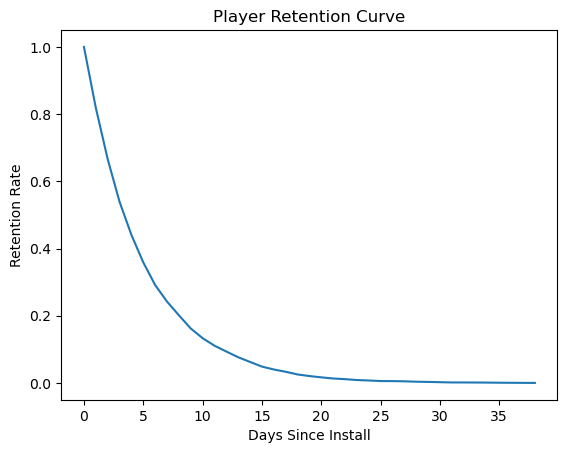

In [16]:
retention_curve = (
    events.groupby("day_diff")["user_id"]
    .nunique()
    / users["user_id"].nunique()
)

retention_curve.plot(
    title="Player Retention Curve",
    xlabel="Days Since Install",
    ylabel="Retention Rate"
)


<Axes: title={'center': 'D1 / D7 / D30 Retention'}, xlabel='Metric'>

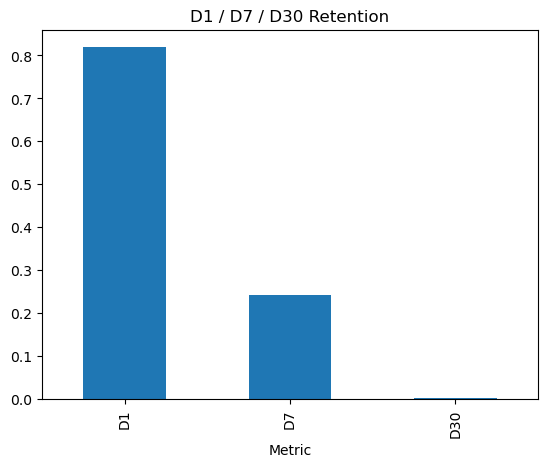

In [17]:
retention_df.set_index("Metric")["Retention Rate"].plot(
    kind="bar",
    title="D1 / D7 / D30 Retention"
)


In [18]:
retention_df["Churn Rate"] = 1 - retention_df["Retention Rate"]
retention_df


,Metric,Retention Rate,Retention Rate (%),Churn Rate
0,D1,0.8188,81.88,0.1812
1,D7,0.2422,24.22,0.7578
2,D30,0.0024,0.24,0.9976


In [20]:
#RETENTION INSIGHTS ENDS HERE-----------------------------------------------------------------------------------------------

In [21]:
# Session Frequency
# How addicted are players?
sessions_per_user = events.groupby("user_id").size()
#Used to:
#Balance rewards
#Prevent burnout
#Design daily caps

sessions_per_user

user_id
1        6
2        4
3       11
4        2
5        6
        ..
4996     8
4997     8
4998     7
4999     6
5000     4
Length: 5000, dtype: int64

In [22]:
# Churn Rate
# Player inactive for X consecutive days

last_active = events.groupby("user_id")["event_date"].max()

churned = last_active < (
    events.event_date.max() - timedelta(days=14)
)

churn_rate = churned.mean()
churn_rate

0.9982

In [26]:
# Cohort Analysis (🔥 VERY IMPORTANT)
#🔹 What is a Cohort?
#Players grouped by install week
users["cohort"] = users.install_date.dt.to_period("W")
events["cohort"] = events.install_date.dt.to_period("W")

#🔹 Cohort Retention Table
cohort_data = events.groupby(
    ["cohort", "day_diff"]
)["user_id"].nunique().reset_index()

cohort_pivot = cohort_data.pivot(
    index="cohort",
    columns="day_diff",
    values="user_id"
)

cohort_size = users.groupby("cohort")["user_id"].nunique()

cohort_retention = cohort_pivot.divide(cohort_size, axis=0)

#cohort_data
#cohort_pivot
#cohort_size
display(cohort_retention)

day_diff,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
cohort,,,,,,,,,,,,,,,,,,,,,
2024-01-01/2024-01-07,1.0,0.815633,0.663551,0.532710,0.430756,0.347494,0.276975,0.230246,0.184367,0.143585,...,0.003398,0.002549,0.002549,0.002549,0.002549,0.001699,0.000850,0.000850,0.000850,0.00085
2024-01-08/2024-01-14,1.0,0.819556,0.672889,0.551111,0.472000,0.383111,0.312889,0.260444,0.221333,0.181333,...,0.003556,0.002667,0.001778,0.001778,0.000889,0.000889,NaN,NaN,NaN,NaN
2024-01-15/2024-01-21,1.0,0.810181,0.661777,0.534944,0.434858,0.352028,0.292494,0.245039,0.202761,0.166523,...,0.001726,0.001726,0.000863,0.000863,0.000863,0.000863,0.000863,NaN,NaN,NaN
2024-01-22/2024-01-28,1.0,0.835284,0.674749,0.546823,0.435619,0.365385,0.294314,0.244983,0.208194,0.168060,...,0.005017,0.003344,0.001672,0.001672,0.001672,0.001672,0.001672,0.001672,0.000836,NaN
2024-01-29/2024-02-04,1.0,0.798834,0.638484,0.510204,0.408163,0.317784,0.259475,0.204082,0.169096,0.128280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


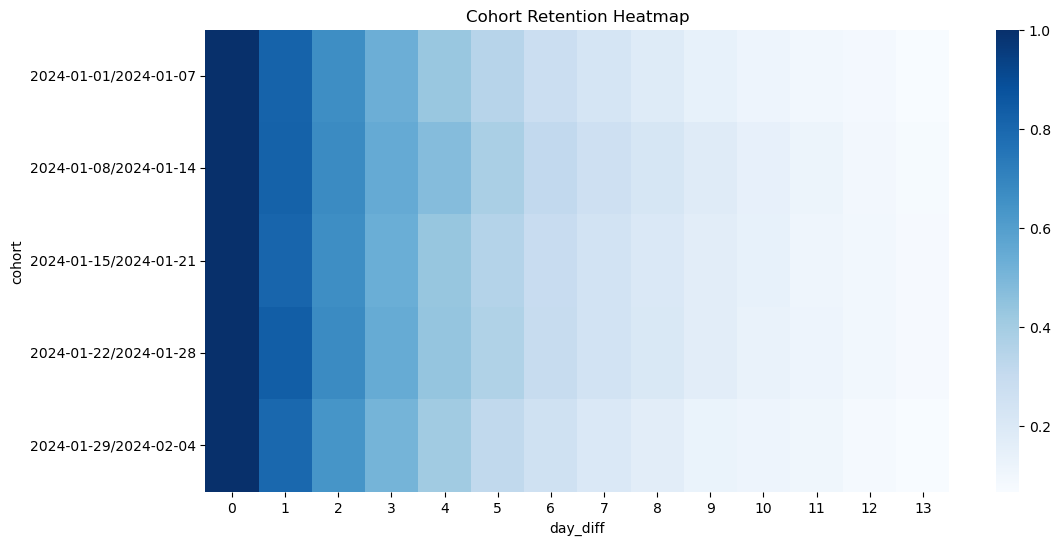

In [27]:
# Cohort Heatmap (INTERVIEW GOLD)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(
    cohort_retention.iloc[:, :14],
    cmap="Blues"
)
plt.title("Cohort Retention Heatmap")
plt.show()